In [1]:
import qiskit
qiskit.__version__

'0.21.0'

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.0', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

# Mitigation the Noisy results with Measurement Errors

In [3]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit import execute, BasicAer,Aer, IBMQ
from qiskit.visualization import *
from qiskit.utils.mitigation import (complete_meas_cal,CompleteMeasFitter)
from qiskit.providers.aer import noise
from qiskit.providers.models import BackendProperties


## Create a 2-qubit Circuit as shown :

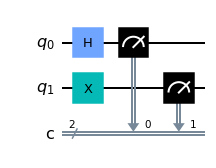

In [4]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.x(1)
 
qc.measure(qc.qregs[0],qc.cregs[0])
qc.draw(output="mpl")

## Generate the counts on the ideal qasm simulator without any noise

In [5]:
# Execute the calibration circuits
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=1000)
results = job.result()
# Results without mitigation
ideal_counts = results.get_counts()

In [6]:
ideal_counts 

{'11': 506, '10': 494}

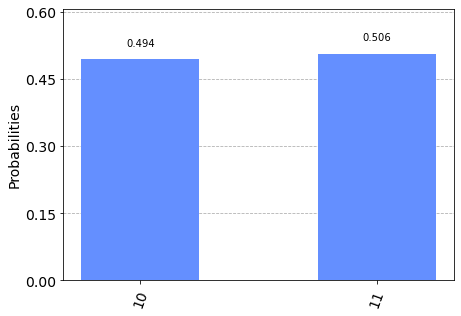

In [7]:
plot_histogram(ideal_counts)

## We have to design a custom noise model  with the readout errors :
- Backend selected : ibmq_quito is a 5-qubit quantum system
- Qubits selected : 2 qubits i.e qubit 1 and qubit 2 from the 5-qubit system of ibmq_quito
- Next, we can access all the different backend properties . Current scenario we have consider only readout errors
- For the custom noise model we have taken into account only the readout errors to obtain mitigated results.

In [8]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_quito')

# Build noise model from backend properties

# Generate a noise model for the 2 qubits
noise_model = noise.NoiseModel()

initial_circuit_layout=[1,2]

for qi in range(2):
 # Measurement miss-assignement probabilities
    qno=initial_circuit_layout[qi]
    p0given1 = backend.properties().qubits[qno][5].value  #prob_meas0_prep1
    p1given0 = backend.properties().qubits[qno][6].value  #prob_meas1_prep0
    read_err = noise.errors.readout_error.ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
    noise_model.add_readout_error(read_err,[qno])

## Observe the noisy counts 

In [9]:
backend = Aer.get_backend('qasm_simulator')

job = execute(qc, backend=backend, shots=1000, noise_model=noise_model,optimization_level=3,initial_layout=[1,2])

result=job.result()

noisy_counts=result.get_counts()

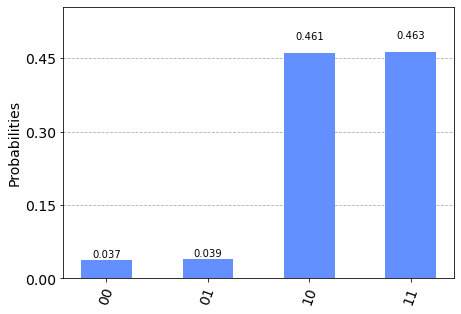

In [10]:
plot_histogram(noisy_counts)

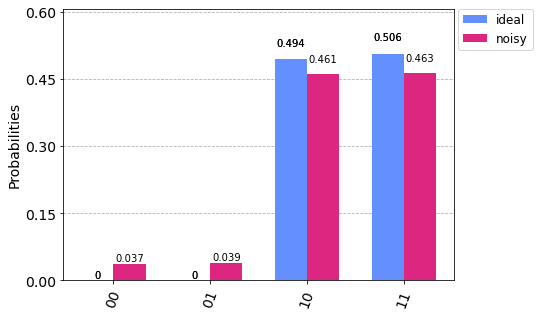

In [11]:
plot_histogram([ideal_counts, noisy_counts], legend=['ideal', 'noisy'])

## Lets perform measurement mitigation to get better results

In [12]:
qr = QuantumRegister(2)

meas_calibs, state_labels = complete_meas_cal(qr=qr ,circlabel='mcal')

# The calibration matrix without noise is the identity matrix

In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)

cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Generate teh calibration matrix of the custom noise model

In [15]:

backend = Aer.get_backend('qasm_simulator')

job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)

cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.963 0.    0.052 0.   ]
 [0.    0.961 0.    0.061]
 [0.037 0.    0.948 0.   ]
 [0.    0.039 0.    0.939]]


### https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

# Create measurement filter object to mitigate the noise
#Using this object we get the mitigated results to calculate the mitigated counts

In [16]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=1000,noise_model=noise_model)

cal_results = job.result()
# create the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(cal_results)
mitigated_counts = mitigated_results.get_counts()

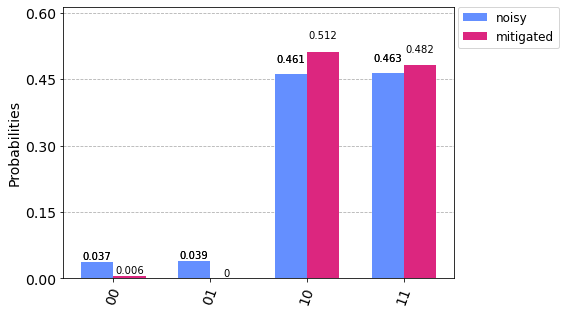

In [17]:
plot_histogram([noisy_counts, mitigated_counts ], legend=['noisy', 'mitigated'])